# Scraping GUS REGON data

---

## Libraries

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import time
import os
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
import undetected_chromedriver as uc
from selenium.webdriver.common.action_chains import ActionChains

## Functions

In [25]:
def front_fill_0 (list, x):
    new_list=[]
    for id in list:
        if len(id)<x:
            id = '0'*(x-len(id))+id
        new_list.append(id)
    return new_list

def contains_letters(string):
    for char in string:
        if char.isalpha():
            return True
    return False

def getText(curElement):
    """
    Get Selenium element text
    Args: curElement (WebElement): selenium web element
    Returns: str
    Raises:
    """
    # # for debug
    # elementHtml = curElement.get_attribute("innerHTML")
    # print("elementHtml=%s" % elementHtml)

    elementText = curElement.text # sometime NOT work
    WebDriverWait(driver, timeout=30)
    if not elementText:
        elementText = curElement.get_attribute("innerText")
    WebDriverWait(driver, timeout=30)
    if not elementText:
        elementText = curElement.get_attribute("textContent")
    WebDriverWait(driver, timeout=30)
    # print("elementText=%s" % elementText)
    return elementText

def list_of_csv_files(dir):
    only_files = [dir + f for f in os.listdir(dir) if f[-4:]=='.csv']
    return only_files

# Turning REGN into 9 digit format

In [ ]:
# Turning REGN into 9 digit format

CompositeAllCoopData = pd.read_csv('Data from rejestr.io/CompositeAllCoopData.csv')
CompositeAllCoopData['numery.regon'] = front_fill_0(CompositeAllCoopData['numery.regon'].astype(str).tolist(),9)

CompositeAllCoopData['numery.regon']

0       523858324
1       523613930
2       522966320
3       521553916
4       389808841
          ...    
3706    191376056
3707    006226018
3708    000981305
3709    000490524
3710    491867589
Name: numery.regon, Length: 3711, dtype: object

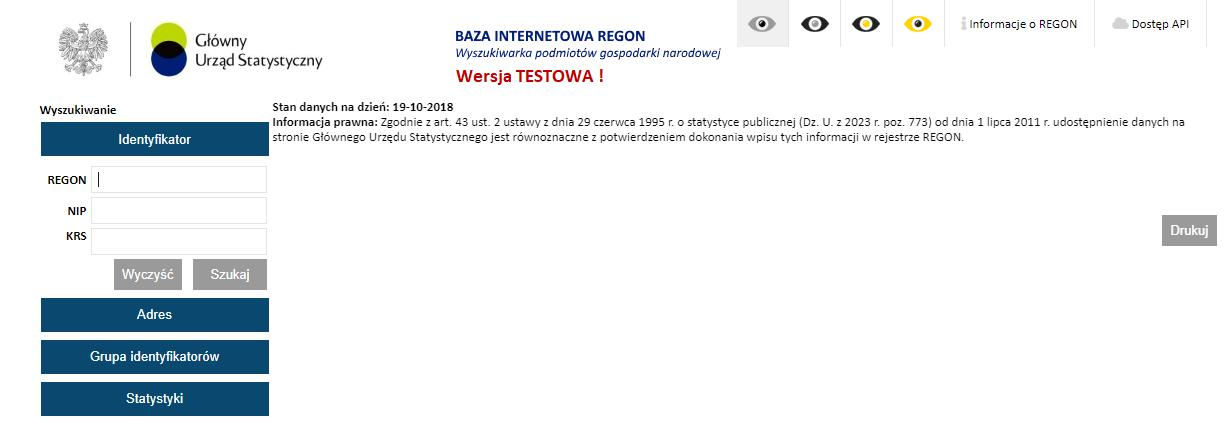

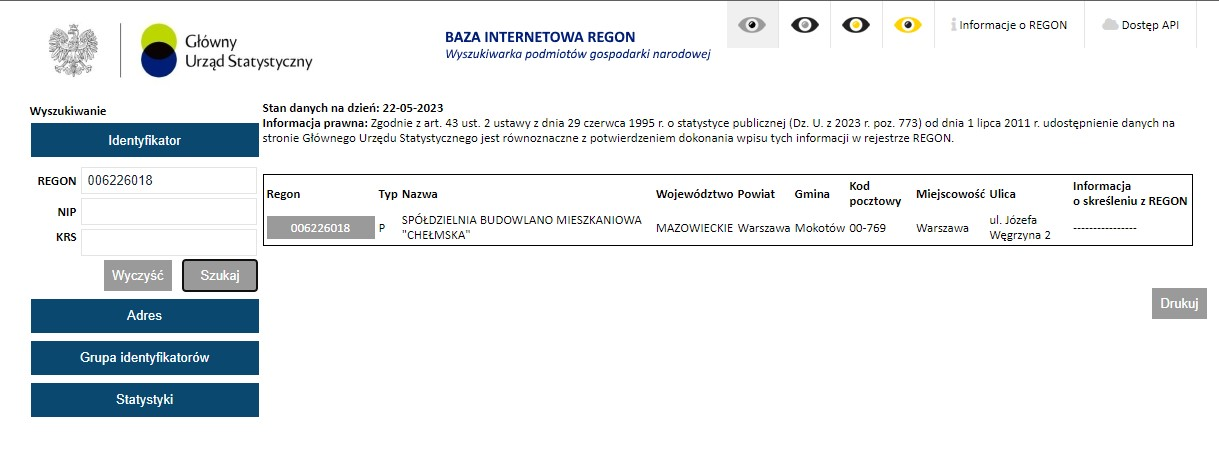

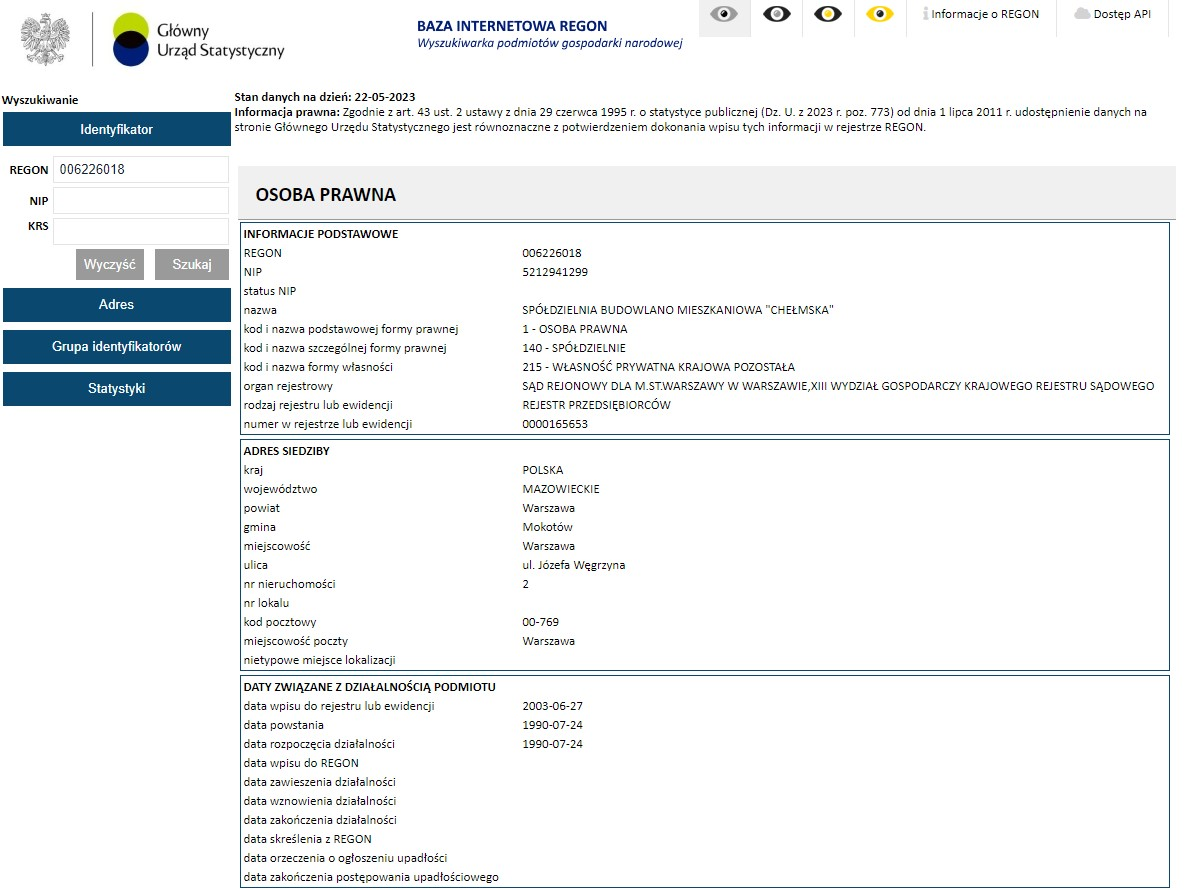

# Single point - TEST

In [61]:
driver = webdriver.Chrome()
url = "https://wyszukiwarkaregontest.stat.gov.pl/appBIR/index.aspx"
driver.get(url)

regon=REGONs0[0]

driver.find_element(by='xpath',value='//*[@id="txtRegon"]').send_keys(regon)
driver.find_element(by='xpath',value='//*[@id="btnSzukaj"]').click()
driver.implicitly_wait(5)
driver.find_element(by='xpath',value='//*[@id="divListaJednostek"]/table/tbody/tr/td[1]/a').click()

driver.implicitly_wait(5)
text = driver.find_element(by='xpath',value='//*[@id="praw_dataRozpoczeciaDzialalnosci"]')
driver.implicitly_wait(5)
data = text.text
print(data)


1975-12-15


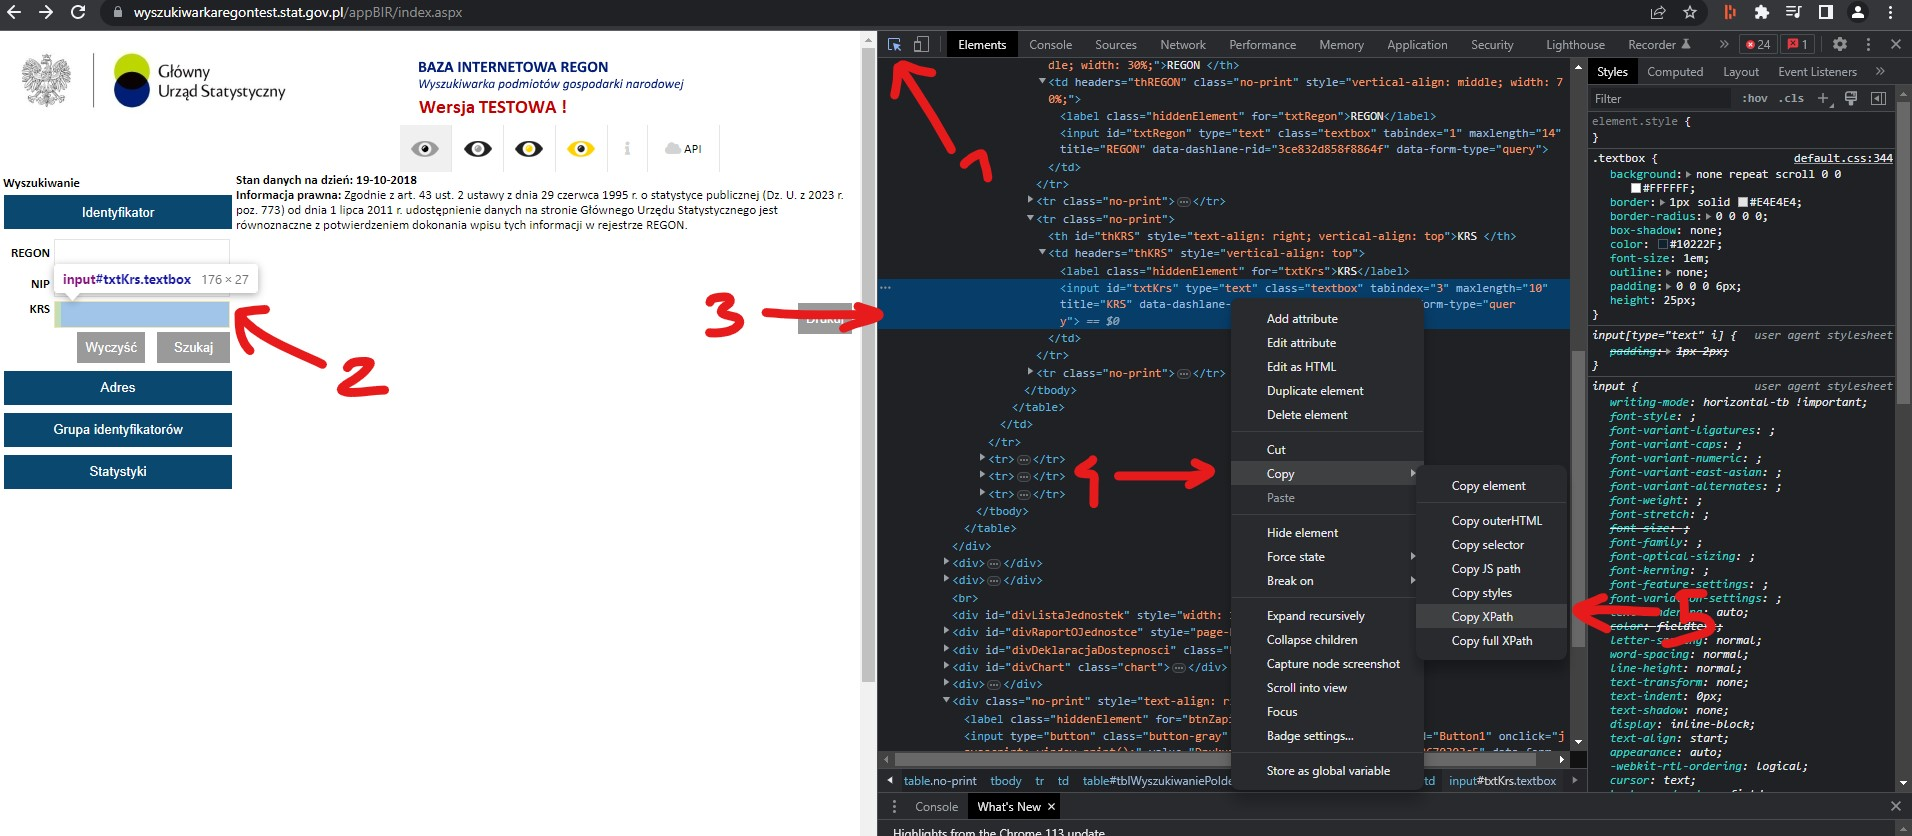

# All points

In [1]:
starting_dates=pd.DataFrame(columns=['regon','data_rozpoczecia_dzialalnosci','data_powstania',])

driver = webdriver.Chrome()
# driver = uc.Chrome()
# url = "https://wyszukiwarkaregontest.stat.gov.pl/appBIR/index.aspx"
# driver.get(url)

url = 'https://bip.stat.gov.pl/dzialalnosc-statystyki-publicznej/rejestr-regon/'
driver.get(url)
driver.find_element(by='xpath',value='//*[@id="txt"]/div/div[2]/div/div[2]/ul/li[2]/a').click()


p = driver.current_window_handle

#get first child window
chwd = driver.window_handles

for w in chwd:
#switch focus to child window
    if(w!=p):
        driver.switch_to.window(w)
        break
time.sleep(0.9)
print("Child window title: " + driver.title)


REGON = CompositeAllCoopData['numery.regon'].tolist()[3650:]

for regon in REGON:
    data_r_d =''
    data_p =''
    driver.implicitly_wait(30)
    
    button = driver.find_element(by='xpath',value='//*[@id="txtRegon"]')
    driver.implicitly_wait(10)
    ActionChains(driver).move_to_element(button).click(button)
    time.sleep(0.5)
    driver.implicitly_wait(5)
    button.send_keys(regon)
    
    
    # driver.find_element(by='xpath',value='//*[@id="txtRegon"]').send_keys(regon)
    driver.find_element(by='xpath',value='//*[@id="btnSzukaj"]').click()
    try:
        driver.implicitly_wait(5)
        driver.find_element(by='xpath',value='//*[@id="divListaJednostek"]/table/tbody/tr/td[1]/a').click()
        driver.implicitly_wait(10)
        curl_r_d = driver.find_element(by='xpath',value='//*[@id="praw_dataRozpoczeciaDzialalnosci"]')
        curl_p = driver.find_element(by='xpath',value='//*[@id="praw_dataPowstania"]')
    
        try_counter=0
        while len(data_r_d)<1 and try_counter <5:
            driver.implicitly_wait(10)
            data_r_d = getText(curl_r_d)
            try_counter +=1
        # print(data_r_d, end='  ')
        print('-',end='')

        try_counter=0
        while len(data_p)<1 and try_counter <5:
            driver.implicitly_wait(10)
            data_p = getText(curl_p)
            try_counter +=1
        # print(data_p)
        print('~',end='')

        new_row = pd.DataFrame.from_dict({'regon':[regon], 'data_rozpoczecia_dzialalnosci':[data_r_d], 'data_powstania':[data_p]})

    except:
        print('error - no value', regon)
        new_row = pd.DataFrame.from_dict({'regon':[regon], 'data_rozpoczecia_dzialalnosci':np.nan, 'data_powstania':np.nan})
        driver.implicitly_wait(10)
        # error_text = driver.find_element(by='xpath',value='if //*[@id="divInfoKomunikat"]').text
        
    
    starting_dates = pd.concat([starting_dates,new_row], axis=0)
    driver.implicitly_wait(10)
    driver.find_element(by='xpath', value='//*[@id="btnOdswiez"]').click()
    driver.implicitly_wait(10)
    
driver.quit()

starting_dates.reset_index().to_csv('Data from regon/Creation_dates_part_4.csv', index=False)
starting_dates

NameError: name 'pd' is not defined

<video controls src='Presentation complimentary files\video_2023-04-04_12-28-09.mp4' width='2500'/>

In [20]:
starting_dates.reset_index().to_csv('Data from regon/Creation_dates_part_4.csv', index=False)
starting_dates

,regon,data_rozpoczecia_dzialalnosci,data _powstania
0,000491624,1975-12-15,1975-12-15
0,001317242,1988-10-12,1988-10-12
0,000421664,1975-12-15,1975-12-15
0,012503401,1991-04-11,1991-04-11
0,001093950,1984-06-13,1984-06-13
...,...,...,...
0,361514073,2015-05-11,2015-05-11
0,330419195,1996-03-12,1996-03-12
0,870250909,1994-01-26,1994-01-26
0,634212850,2001-07-25,2001-07-25


In [21]:
len(CompositeAllCoopData['numery.regon'].tolist()[3650:])

61

In [55]:
Creation_dates['data_rozpoczecia_dzialalnosci'].astype(datetime)

NameError: name 'datetime' is not defined

In [2]:
pd.to_datetime(Creation_dates['data_rozpoczecia_dzialalnosci']).hist(bins=30)

NameError: name 'pd' is not defined

<Axes: >

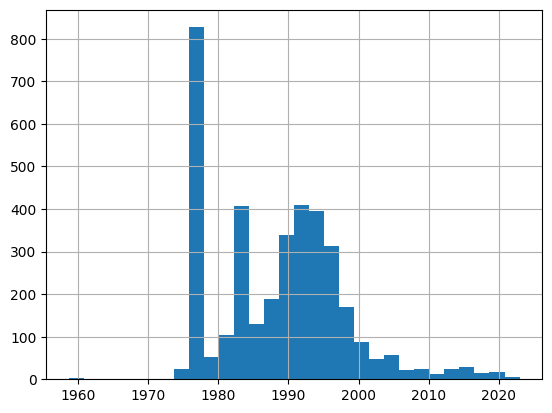

In [64]:
pd.to_datetime(Creation_dates['data _powstania']).hist(bins=30)